In [1]:
import sys, os
sys.path.append(os.path.abspath('/spark-data'))

In [2]:
#Importing Spark Session and important libraries that need to perform things in project
from utils.Data_Ingestion.data_ingestion import load_files 
from pyspark.sql import SparkSession

In [3]:
# Initialize Spark session with both configurations
spark = SparkSession.builder \
    .appName("Big_Data_Processing") \
    .config("spark.driver.memory", "4g") \
    .config("spark.executor.memory", "4g") \
    .config("spark.jars.packages", "org.postgresql:postgresql:42.2.20,com.crealytics:spark-excel_2.12:3.4.1_0.19.0") \
    .getOrCreate()

:: loading settings :: url = jar:file:/opt/bitnami/spark/jars/ivy-2.5.1.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /root/.ivy2/cache
The jars for the packages stored in: /root/.ivy2/jars
org.postgresql#postgresql added as a dependency
com.crealytics#spark-excel_2.12 added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-87fab764-88ee-4c23-94c9-fc1c17d8dfe5;1.0
	confs: [default]
	found org.postgresql#postgresql;42.2.20 in central
	found org.checkerframework#checker-qual;3.5.0 in central
	found com.crealytics#spark-excel_2.12;3.4.1_0.19.0 in central
	found org.apache.poi#poi;5.2.3 in central
	found commons-codec#commons-codec;1.15 in central
	found org.apache.commons#commons-collections4;4.4 in central
	found org.apache.commons#commons-math3;3.6.1 in central
	found com.zaxxer#SparseBitSet;1.2 in central
	found org.apache.poi#poi-ooxml;5.2.3 in central
	found org.apache.poi#poi-ooxml-lite;5.2.3 in central
	found org.apache.xmlbeans#xmlbeans;5.1.1 in central
	found com.github.virtuald#curvesapi;1.07 in central
	found com.norbitltd#spoiwo_2.12;2

In [4]:
dfs = load_files(spark, "/spark-data/Data_Files")

2024-09-19 08:55:20,254 - INFO - Checking if JSON file is empty: /spark-data/Data_Files/data.json
2024-09-19 08:55:24,910 - INFO - JSON file /spark-data/Data_Files/data.json is not empty.
2024-09-19 08:55:25,365 - INFO - Successfully processed nested JSON field 'orders' in file: /spark-data/Data_Files/data.json
2024-09-19 08:55:25,441 - INFO - Successfully processed nested JSON field 'reviews' in file: /spark-data/Data_Files/data.json
2024-09-19 08:55:25,442 - INFO - Checking if EXCEL file is empty: /spark-data/Data_Files/data.xlsx
2024-09-19 08:55:31,707 - INFO - Excel file /spark-data/Data_Files/data.xlsx is not empty.
2024-09-19 08:55:32,703 - INFO - Successfully loaded sheet 'data' from Excel file: /spark-data/Data_Files/data.xlsx
2024-09-19 08:55:33,299 - INFO - Successfully loaded sheet 'product' from Excel file: /spark-data/Data_Files/data.xlsx
2024-09-19 08:55:33,915 - INFO - Successfully loaded sheet 'customer' from Excel file: /spark-data/Data_Files/data.xlsx


In [5]:
dfs["df_data_data"].show()

+--------+-----------+-------------------+------------+--------------------+--------------------+
|order_id|customer_id|         order_date|total_amount|    shipping_address|     billing_address|
+--------+-----------+-------------------+------------+--------------------+--------------------+
|     1.0|      462.0|2019-08-26 00:00:00|      4007.0|60585 Moore Overp...|775 Roberson Knol...|
|     2.0|     2820.0|2021-04-22 00:00:00|      7240.0|3278 Price Isle\n...|2055 Curry Street...|
|     3.0|     1934.0|2024-02-21 00:00:00|      8318.0|Unit 8425 Box 079...|USNV Strong\nFPO ...|
|     4.0|     2694.0|2021-01-14 00:00:00|      4992.0|5566 Brittany Sta...|524 Allen Shoal S...|
|     5.0|      134.0|2020-03-14 00:00:00|      5385.0|4289 Michael Esta...|38637 Cheryl Junc...|
|     6.0|     4651.0|2020-12-30 00:00:00|      3512.0|83184 Shelly Land...|80329 Dawn Road S...|
|     7.0|     1696.0|2023-05-30 00:00:00|      4592.0|7127 Arroyo Land\...|787 Smith Islands...|
|     8.0|     1969.

In [6]:
order = dfs["df_data_data"]
customer = dfs["df_data_customer"]
review = dfs["df_data_reviews"]
order_item = dfs["df_data_orders"]
product = dfs["df_data_product"]

In [7]:
customer.printSchema()
order.printSchema()
product.printSchema()
order_item.printSchema()
review.printSchema()

root
 |-- customer_id: double (nullable = true)
 |-- first_name: string (nullable = true)
 |-- last_name: string (nullable = true)
 |-- email: string (nullable = true)
 |-- phone_number: string (nullable = true)
 |-- city: string (nullable = true)
 |-- state: string (nullable = true)
 |-- zip_code: double (nullable = true)
 |-- birth_date: timestamp (nullable = true)

root
 |-- order_id: double (nullable = true)
 |-- customer_id: double (nullable = true)
 |-- order_date: timestamp (nullable = true)
 |-- total_amount: double (nullable = true)
 |-- shipping_address: string (nullable = true)
 |-- billing_address: string (nullable = true)

root
 |-- product_id: double (nullable = true)
 |-- product_name: string (nullable = true)
 |-- category: string (nullable = true)
 |-- price: double (nullable = true)
 |-- description: string (nullable = true)
 |-- inventory: double (nullable = true)

root
 |-- order_id: long (nullable = true)
 |-- order_item_id: long (nullable = true)
 |-- price: long 

# Apply Data Cleaning on all dataframe

In [8]:
dataframes = {
    'customer': customer,
    'order': order,
    'product': product,
    'order_item': order_item,
    'review': review
}

In [9]:
from utils.Data_Cleaning.data_cleaning import data_cleaning_pipeline

In [10]:
import yaml

# Load the configuration from the YAML file
with open('spark-data/config.yaml', 'r') as file:
    config = yaml.safe_load(file)

In [11]:
cleaning_config = config.get('cleaning', {})

In [12]:
dfs = data_cleaning_pipeline(dataframes, cleaning_config, spark)

2024-09-19 08:55:35,790 - INFO - Analyzing DataFrame: customer
2024-09-19 08:55:44,178 - INFO - Analyzing DataFrame: order
2024-09-19 08:55:49,428 - INFO - Analyzing DataFrame: product
2024-09-19 08:55:54,135 - INFO - Analyzing DataFrame: order_item
2024-09-19 08:55:55,135 - INFO - Analyzing DataFrame: review
2024-09-19 08:55:56,589 - INFO - Analysis DataFrame created successfully.
2024-09-19 08:55:56,590 - INFO - Starting cleaning process for customer
2024-09-19 08:55:56,591 - INFO - Applying remove_duplicates with params {}
2024-09-19 08:55:56,592 - WARNING - No parameters provided for remove_duplicates, skipping.
2024-09-19 08:55:56,592 - INFO - Applying remove_decimal with params {'columns': ['customer_id', 'zip_code']}
2024-09-19 08:55:56,619 - INFO - Successfully removed decimal values from column 'customer_id'.
2024-09-19 08:55:56,633 - INFO - Successfully removed decimal values from column 'zip_code'.
2024-09-19 08:55:57,104 - INFO - Applying handle_negative_values with params 

In [13]:
customer = dfs["customer"]
order = dfs["order"]
product = dfs["product"]
order_item = dfs["order_item"]
review = dfs["review"]

In [14]:
customer.printSchema()
order.printSchema()
product.printSchema()
order_item.printSchema()
review.printSchema()

root
 |-- customer_id: long (nullable = true)
 |-- first_name: string (nullable = true)
 |-- last_name: string (nullable = true)
 |-- email: string (nullable = true)
 |-- phone_number: string (nullable = true)
 |-- city: string (nullable = true)
 |-- state: string (nullable = true)
 |-- zip_code: string (nullable = true)
 |-- birth_date: date (nullable = true)

root
 |-- order_id: long (nullable = true)
 |-- customer_id: long (nullable = true)
 |-- order_date: date (nullable = true)
 |-- total_amount: long (nullable = true)
 |-- shipping_address: string (nullable = true)
 |-- billing_address: string (nullable = true)

root
 |-- product_id: long (nullable = true)
 |-- product_name: string (nullable = true)
 |-- category: string (nullable = true)
 |-- price: double (nullable = true)
 |-- description: string (nullable = true)
 |-- inventory: integer (nullable = true)

root
 |-- order_id: long (nullable = true)
 |-- order_item_id: long (nullable = true)
 |-- price: integer (nullable = true

In [15]:
customer.show()

+-----------+-----------+---------+--------------------+--------------------+-----------------+-------------+--------+----------+
|customer_id| first_name|last_name|               email|        phone_number|             city|        state|zip_code|birth_date|
+-----------+-----------+---------+--------------------+--------------------+-----------------+-------------+--------+----------+
|          1|    Crystal|  Edwards|mcmahonemily@exam...|   +1 (511) 782-4381|    Fergusonville|         Iowa|   91344|1995-02-28|
|          2|   Jennifer|    Jones|douglasedwards@ex...|   +1 (918) 720-2495|     Jenniferport|   New Jersey|   59371|1951-01-27|
|          3|  Catherine|    Crane|douglaskevin@exam...|+1 (381) 601-2272...|  Jenniferchester|West Virginia|   49812|1966-10-07|
|          4|     Lauren|    Irwin|aguirresteven@exa...|Invalid phone number|      New Melissa|     Michigan|   17279|1936-07-28|
|          5|Christopher|   Nelson|dustin50@example.org|+1 (735) 814-4145...|       Hannah

In [16]:
order.show()

+--------+-----------+----------+------------+--------------------+--------------------+
|order_id|customer_id|order_date|total_amount|    shipping_address|     billing_address|
+--------+-----------+----------+------------+--------------------+--------------------+
|       1|        462|2019-08-26|        4007|60585 Moore Overp...|775 Roberson Knol...|
|       2|       2820|2021-04-22|        7240|3278 Price IsleNo...|2055 Curry Street...|
|       3|       1934|2024-02-21|        8318|Unit 8425 Box 079...|USNV StrongFPO AP...|
|       4|       2694|2021-01-14|        4992|5566 Brittany Sta...|524 Allen Shoal S...|
|       5|        134|2020-03-14|        5385|4289 Michael Esta...|38637 Cheryl Junc...|
|       6|       4651|2020-12-30|        3512|83184 Shelly Land...|80329 Dawn Road S...|
|       7|       1696|2023-05-30|        4592|7127 Arroyo LandP...|787 Smith Islands...|
|       8|       1969|2021-05-03|        6640|29076 Robinson Ca...|65198 Anderson Ex...|
|       9|       2220

In [17]:
product.show()

+----------+-------------+---------+-----+--------------------+---------+
|product_id| product_name| category|price|         description|inventory|
+----------+-------------+---------+-----+--------------------+---------+
|         1|          bag|       no|448.0|Summer now health...|      655|
|         2|        happy|   answer|844.0|Employee discuss ...|      230|
|         3|         same|      his|681.0|Million mother pu...|      831|
|         4|      prevent|   around| 34.0|Because under mea...|      804|
|         5|        quite|   summer|663.0|Approach Mr task ...|      351|
|         6|        which|  purpose|386.0|Leave charge mode...|       10|
|         7|       beyond|   beyond|879.0|Shoulder power in...|      282|
|         8|     although|     home|650.0|Exactly continue ...|      818|
|         9|environmental| although|  7.0|Really admit kind...|      128|
|        10|       assume|professor|945.0|Bar truth here gr...|      168|
|        11|      usually|   figure|43

In [18]:
order_item.show()

+--------+-------------+-----+----------+--------+
|order_id|order_item_id|price|product_id|quantity|
+--------+-------------+-----+----------+--------+
|     868|            1|   70|      1571|       7|
|    3151|            2|    8|      3809|       3|
|    1582|            3|   32|      4896|       8|
|    2578|            4|   64|      2712|       4|
|    2792|            5|   53|      1111|       4|
|    1257|            6|   69|      2874|       1|
|    2389|            7|   40|      2670|       9|
|    2013|            8|   39|      3779|       6|
|    4272|            9|   15|      3109|       5|
|    1260|           10|   21|      2110|       8|
|    3617|           11|   27|      3350|       1|
|    1479|           12|   96|      2917|       9|
|    1405|           13|   61|      1480|       5|
|    4526|           14|   69|      4686|       5|
|    2513|           15|    8|      3146|       8|
|    2346|           16|   92|      4182|       5|
|    3988|           17|   88| 

In [19]:
review.show()

+-----------+----------+------+-----------+---------+--------------------+
|customer_id|product_id|rating|review_date|review_id|         review_text|
+-----------+----------+------+-----------+---------+--------------------+
|       2522|      4663|     3| 2022-12-20|        1|Home create anyon...|
|       2181|      2645|     3| 2024-07-05|        2|Skill herself opt...|
|       3935|      1699|     3| 2024-05-06|        3|Public everyone s...|
|       3453|      1360|     1| 2023-11-05|        4|Level land majori...|
|       2999|      4883|     3| 2024-03-03|        5|Treat fine now di...|
|        863|      3544|     2| 2023-06-02|        6|Land despite buy ...|
|       2348|      1853|     1| 2023-11-11|        7|Ground again goal...|
|       2388|      1652|     3| 2022-11-29|        8|Community materia...|
|       4486|       632|     4| 2023-03-31|        9|Goal after color ...|
|       1379|      2399|     5| 2024-02-11|       10|Beyond coach meet...|
|        309|      3241| 

# Data Transformation

In [20]:
df_for_transformation = {
    'customer': customer,
    'order': order
}

In [21]:
transformation_config = config.get('transformations', {})


In [22]:
from utils.Data_Transformation.transformation import data_transformation_pipeline

In [23]:
# Apply the transformation pipeline
dfs = data_transformation_pipeline(df_for_transformation, transformation_config)

2024-09-19 08:56:39,489 - INFO - Starting transformation process for customer
2024-09-19 08:56:39,492 - INFO - Applying add_age_column with params {'birth_date_column': 'birth_date'}
2024-09-19 08:56:39,494 - INFO - Starting to add 'age' column based on the birth date column.
2024-09-19 08:56:39,496 - INFO - Column 'birth_date' found. Calculating age, handling 'Invalid Date' if present.
2024-09-19 08:56:39,543 - INFO - Age column added successfully.
2024-09-19 08:56:39,544 - INFO - Successfully applied add_age_column to customer
2024-09-19 08:56:39,547 - INFO - Completed transformation process for customer
2024-09-19 08:56:39,548 - INFO - Starting transformation process for order
2024-09-19 08:56:39,549 - INFO - Applying add_state_columns with params {'shipping_col': 'shipping_address', 'billing_col': 'billing_address'}
2024-09-19 08:56:39,551 - INFO - Starting to add state columns based on the specified address columns.
2024-09-19 08:56:39,553 - INFO - Columns 'shipping_address' and '

In [24]:
dfs

{'customer': DataFrame[customer_id: bigint, first_name: string, last_name: string, email: string, phone_number: string, city: string, state: string, zip_code: string, birth_date: date, age: bigint],
 'order': DataFrame[order_id: bigint, customer_id: bigint, order_date: date, total_amount: bigint, shipping_address: string, billing_address: string, shipping_state: string, billing_state: string]}

In [25]:
customer = dfs["customer"]
order = dfs["order"]

In [26]:
customer.show()

+-----------+-----------+---------+--------------------+--------------------+-----------------+-------------+--------+----------+---+
|customer_id| first_name|last_name|               email|        phone_number|             city|        state|zip_code|birth_date|age|
+-----------+-----------+---------+--------------------+--------------------+-----------------+-------------+--------+----------+---+
|          1|    Crystal|  Edwards|mcmahonemily@exam...|   +1 (511) 782-4381|    Fergusonville|         Iowa|   91344|1995-02-28| 29|
|          2|   Jennifer|    Jones|douglasedwards@ex...|   +1 (918) 720-2495|     Jenniferport|   New Jersey|   59371|1951-01-27| 73|
|          3|  Catherine|    Crane|douglaskevin@exam...|+1 (381) 601-2272...|  Jenniferchester|West Virginia|   49812|1966-10-07| 57|
|          4|     Lauren|    Irwin|aguirresteven@exa...|Invalid phone number|      New Melissa|     Michigan|   17279|1936-07-28| 88|
|          5|Christopher|   Nelson|dustin50@example.org|+1 (73

In [27]:
order.show()

+--------+-----------+----------+------------+--------------------+--------------------+--------------+-------------+
|order_id|customer_id|order_date|total_amount|    shipping_address|     billing_address|shipping_state|billing_state|
+--------+-----------+----------+------------+--------------------+--------------------+--------------+-------------+
|       1|        462|2019-08-26|        4007|60585 Moore Overp...|775 Roberson Knol...|            MI|           DE|
|       2|       2820|2021-04-22|        7240|3278 Price IsleNo...|2055 Curry Street...|            AZ|Not Available|
|       3|       1934|2024-02-21|        8318|Unit 8425 Box 079...|USNV StrongFPO AP...| Not Available|Not Available|
|       4|       2694|2021-01-14|        4992|5566 Brittany Sta...|524 Allen Shoal S...|            ND|           KY|
|       5|        134|2020-03-14|        5385|4289 Michael Esta...|38637 Cheryl Junc...| Not Available|Not Available|
|       6|       4651|2020-12-30|        3512|83184 Shel

# Save Transformed Dataframes into postgreSQL

In [28]:
from utils.postgres_setup import save_dfs_to_postgres_upsert

In [29]:
postgres_config = config['postgresql']
jdbc_url = postgres_config['jdbc_url']
properties = postgres_config['properties']
unique_keys = postgres_config['unique_keys']

In [30]:
customer.printSchema()

root
 |-- customer_id: long (nullable = true)
 |-- first_name: string (nullable = true)
 |-- last_name: string (nullable = true)
 |-- email: string (nullable = true)
 |-- phone_number: string (nullable = true)
 |-- city: string (nullable = true)
 |-- state: string (nullable = true)
 |-- zip_code: string (nullable = true)
 |-- birth_date: date (nullable = true)
 |-- age: long (nullable = true)



In [31]:
save_dfs_to_postgres_upsert(jdbc_url, properties, unique_key_columns=unique_keys, review = review, product = product, order_item = order_item, customer = customer, orders = order)

2024-09-19 08:56:43,535 - INFO - DataFrame review upserted into PostgreSQL.     
2024-09-19 08:56:44,667 - INFO - DataFrame product upserted into PostgreSQL.
2024-09-19 08:56:45,483 - INFO - DataFrame order_item upserted into PostgreSQL.
2024-09-19 08:56:47,777 - INFO - DataFrame customer upserted into PostgreSQL.   
2024-09-19 08:56:48,762 - INFO - DataFrame orders upserted into PostgreSQL.


# Insights and Visulizaition 

### Top 10 Selling Products

In [32]:
from utils.Data_Visualization.visualization import get_top_selling_products

2024-09-19 08:56:50,082 - INFO - Starting the process to get top selling products.
2024-09-19 08:56:50,087 - INFO - Joining order_item and product DataFrames.
2024-09-19 08:56:50,170 - INFO - Aggregating total quantities by product name.
2024-09-19 08:56:50,207 - INFO - Sorting products by total quantity and selecting the top 10.
2024-09-19 08:56:50,236 - INFO - Collecting the top products data.
2024-09-19 08:56:52,728 - INFO - Plotting the top selling products.


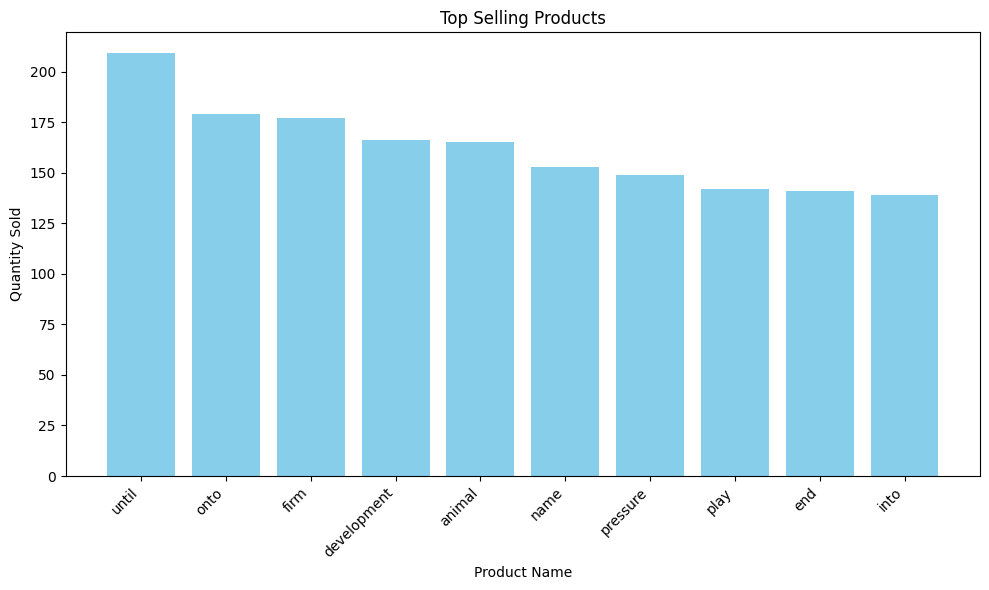

2024-09-19 08:56:52,937 - INFO - Successfully completed the plotting of top selling products.


In [33]:
get_top_selling_products(df_order_item=order_item, df_product=product, product_id_col="product_id", product_name_col="product_name", quantity_col="quantity", top_n=10)

### Top N product purchase by age groups

In [34]:
from utils.Data_Visualization.visualization import get_top_products_by_age_group

2024-09-19 08:56:52,984 - INFO - Calculating customer age and creating age groups.
2024-09-19 08:56:53,043 - INFO - Joining customer, order, and order item DataFrames.
2024-09-19 08:56:53,108 - INFO - Aggregating product purchases by age group and product.
2024-09-19 08:56:53,152 - INFO - Retrieving the top 5 products for each age group.
2024-09-19 08:56:53,249 - INFO - Joining with product names for top products.
2024-09-19 08:56:53,286 - INFO - Collecting data for plotting.
2024-09-19 08:56:56,761 - INFO - Plotting the top 5 products by age group.


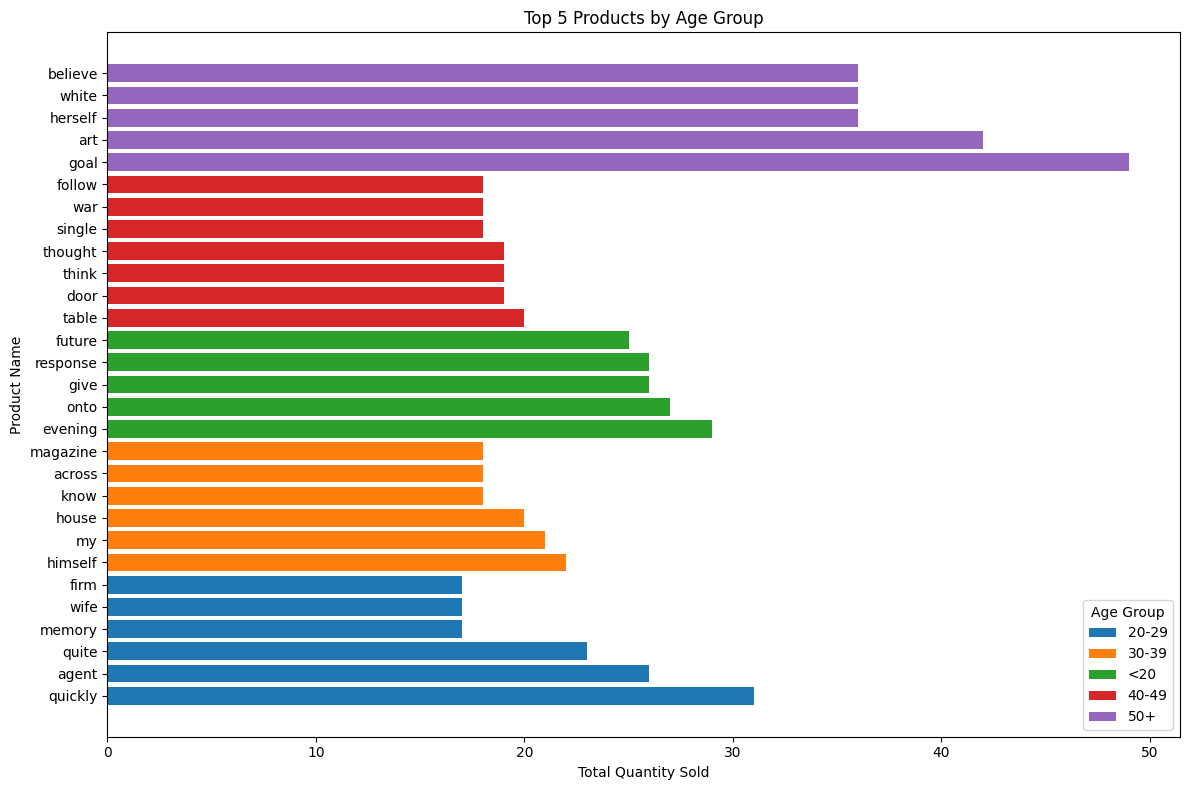

2024-09-19 08:56:57,112 - INFO - Successfully completed the top 5 products by age group plotting.


In [35]:
get_top_products_by_age_group(df_customer=customer, df_order=order, df_order_items=order_item, df_product=product, customer_id_col="customer_id", product_id_col="product_id", order_id_col="order_id", quantity_col="quantity", product_name_col="product_name", age_col="age", top_n=5)

### Top 10 Highest Revenue Generating Products

In [36]:
from utils.Data_Visualization.visualization import  get_top_revenue_generating_products

2024-09-19 08:56:57,147 - INFO - Joining order items and product DataFrames.
2024-09-19 08:56:57,178 - INFO - Calculating revenue for each product.
2024-09-19 08:56:57,195 - INFO - Aggregating total revenue by product name.
2024-09-19 08:56:57,220 - INFO - Sorting products by total revenue and selecting the top 10.
2024-09-19 08:56:57,235 - INFO - Collecting the top products by revenue data.
2024-09-19 08:56:58,754 - INFO - Plotting the top revenue-generating products.


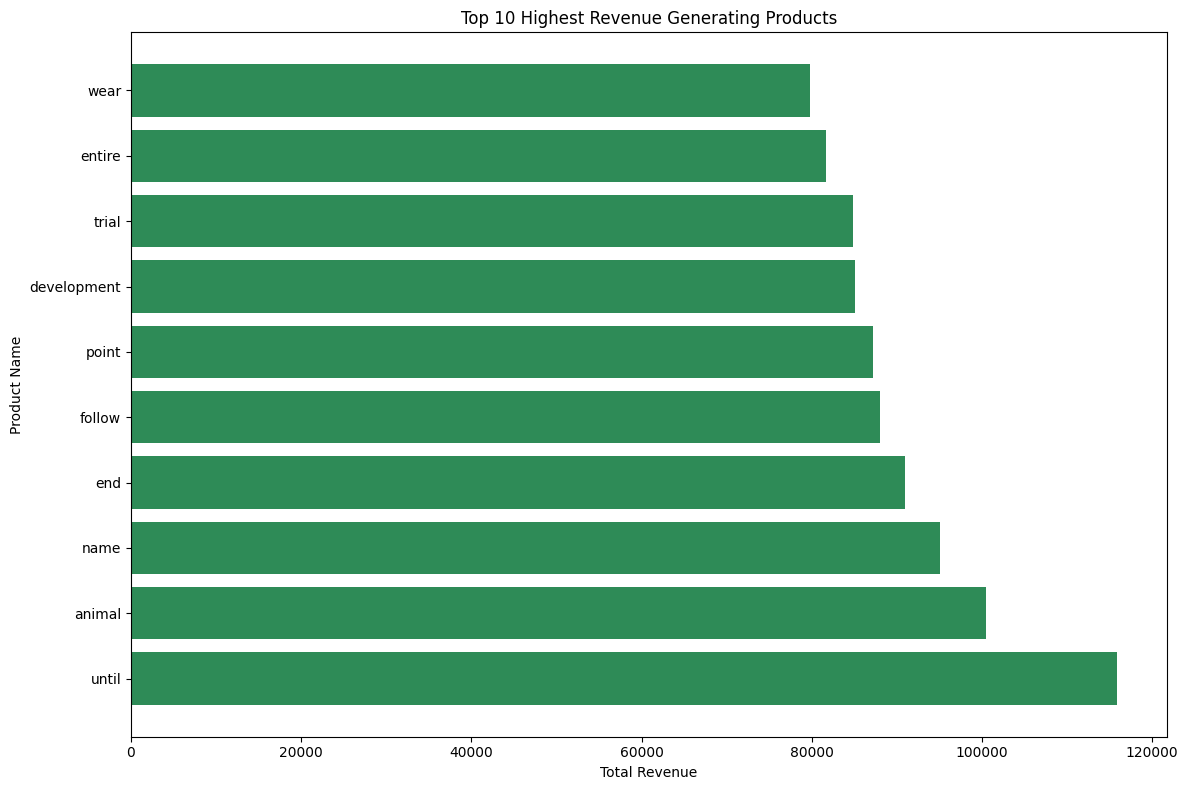

2024-09-19 08:56:58,920 - INFO - Successfully completed the top 10 highest revenue-generating products plotting.


In [37]:
get_top_revenue_generating_products(df_order_items=order_item, df_product=product, product_id_col="product_id", quantity_col="quantity", price_col="price", product_name_col="product_name", top_n=10)

### Top N Frequent ordered products

In [38]:
from utils.Data_Visualization.visualization import  get_frequently_ordered_products

2024-09-19 08:56:58,955 - INFO - Starting the process to calculate the most frequently ordered products.
2024-09-19 08:56:58,957 - INFO - Joining order items and product DataFrames.
2024-09-19 08:56:58,978 - INFO - Aggregating the number of times each product was ordered.


2024-09-19 08:56:59,000 - INFO - Sorting products by order count and selecting the top 10.
2024-09-19 08:56:59,016 - INFO - Collecting the top frequently ordered products data.
2024-09-19 08:57:00,426 - INFO - Plotting the top frequently ordered products.


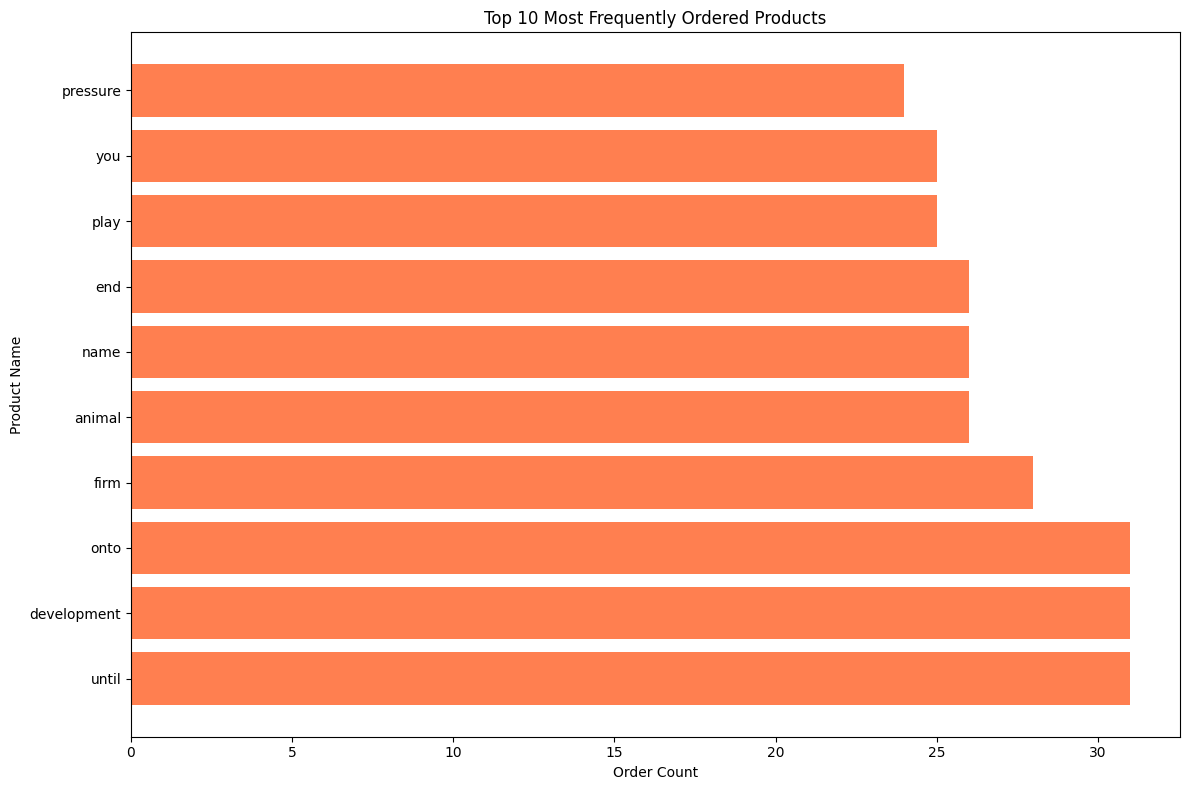

2024-09-19 08:57:00,582 - INFO - Successfully completed the top 10 frequently ordered products plotting.


In [39]:
get_frequently_ordered_products(df_order_items=order_item, df_product=product, product_id_col="product_id", product_name_col="product_name", top_n=10)

### Top N Frequently Ordered Product by Year

In [40]:
from utils.Data_Visualization.visualization import get_frequently_ordered_products_by_year

2024-09-19 08:57:00,609 - INFO - Starting the process to calculate the most frequently ordered products for the year 2023.
2024-09-19 08:57:00,612 - INFO - Filtering orders for the year 2023.
2024-09-19 08:57:00,627 - INFO - Joining filtered orders, order items, and product DataFrames.
2024-09-19 08:57:00,680 - INFO - Aggregating the number of times each product was ordered.
2024-09-19 08:57:00,704 - INFO - Sorting products by order count and selecting the top 10.
2024-09-19 08:57:00,727 - INFO - Collecting the top frequently ordered products data.
24/09/19 08:57:04 ERROR CodeGenerator: failed to compile: org.codehaus.commons.compiler.InternalCompilerException: Compiling "GeneratedClass" in File 'generated.java', Line 1, Column 1: File 'generated.java', Line 137, Column 14: Compiling "hashAgg_doAggregateWithKeys_0()"
org.codehaus.commons.compiler.InternalCompilerException: Compiling "GeneratedClass" in File 'generated.java', Line 1, Column 1: File 'generated.java', Line 137, Column 14:

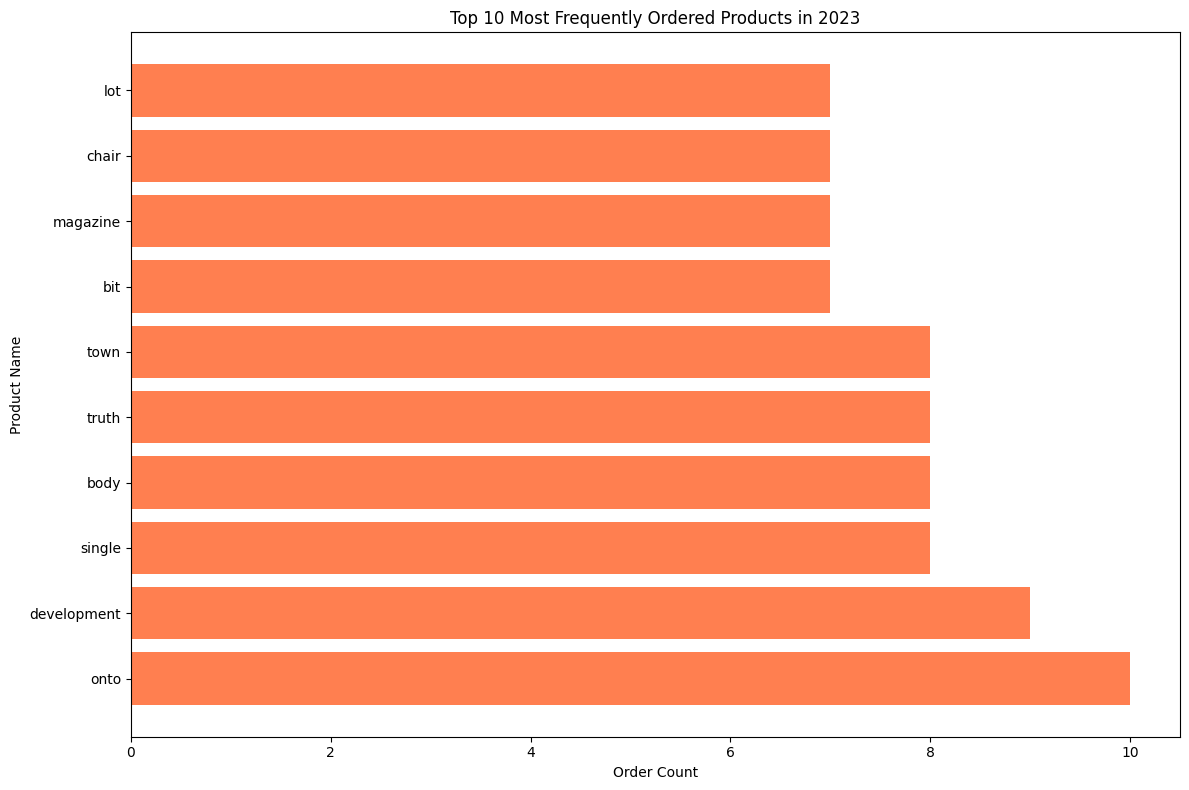

2024-09-19 08:57:05,756 - INFO - Successfully completed the top 10 frequently ordered products for the year 2023.


In [41]:
get_frequently_ordered_products_by_year(df_order_items=order_item, df_product=product, df_order=order, order_id_col="order_id", product_id_col="product_id", product_name_col="product_name", order_date_col="order_date", year_filter=2023, top_n=10)

### Frequently Ordered Product by Age Category Group 

In [42]:
from utils.Data_Visualization.visualization import get_frequently_ordered_products_by_age_group

2024-09-19 08:57:05,790 - INFO - Starting the process to calculate the most frequently ordered products by customer age group.
2024-09-19 08:57:05,792 - INFO - Calculating customer age and creating age groups.
2024-09-19 08:57:05,857 - INFO - Joining customers, orders, order items, and products DataFrames.
2024-09-19 08:57:05,907 - INFO - Aggregating order counts by age group and product.
2024-09-19 08:57:05,925 - INFO - Finding the top 2 products for each age group.
2024-09-19 08:57:05,958 - INFO - Collecting the top products data for each age group.
2024-09-19 08:57:08,488 - INFO - Preparing data for plotting.


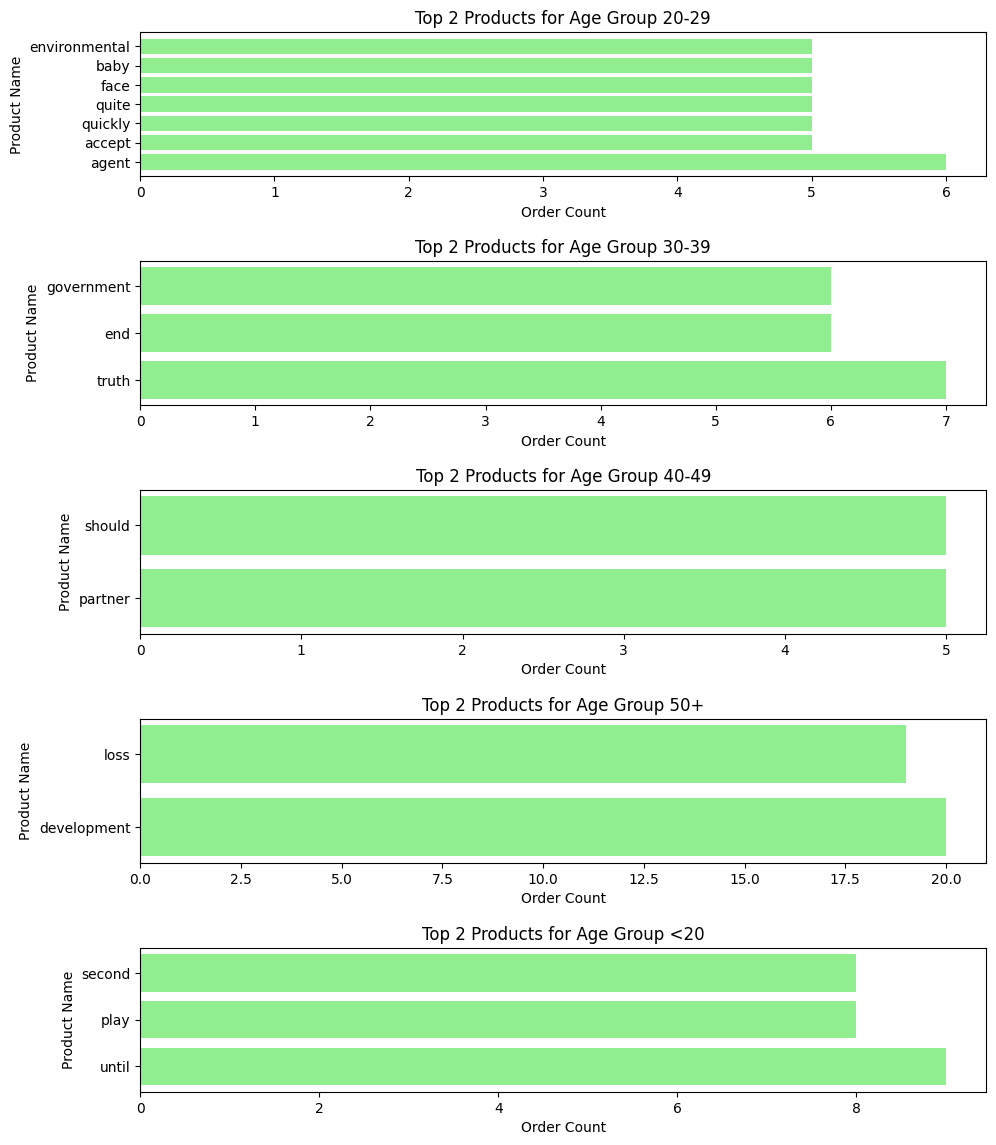

2024-09-19 08:57:09,049 - INFO - Successfully plotted the top products by age group.


In [43]:
get_frequently_ordered_products_by_age_group(df_order_items=order_item, df_product=product, df_order=order,df_customer=customer , order_id_col="order_id", product_id_col="product_id", product_name_col="product_name", customer_id_col="customer_id" ,order_date_col="order_date", birth_date_col="birth_date", top_n=2 )

### Get Average Revenue by product category

In [44]:
from utils.Data_Visualization.visualization import get_average_revenue_by_category

In [45]:
df_get_average_revenue_by_category = get_average_revenue_by_category(df_order_items=order_item, df_product=product, product_id_col="product_id", quantity_col="quantity", price_col="price", category_col="category")

2024-09-19 08:57:09,101 - INFO - Starting the process to calculate average revenue by product category.
2024-09-19 08:57:09,105 - INFO - Renaming price column in order items to avoid ambiguity.
2024-09-19 08:57:09,116 - INFO - Joining order items with products to calculate revenue.
2024-09-19 08:57:09,146 - INFO - Calculating revenue for each product (order_price * quantity).
2024-09-19 08:57:09,171 - INFO - Grouping by product category and calculating average revenue.
2024-09-19 08:57:09,211 - INFO - Successfully calculated average revenue by category. Returning the DataFrame.


In [46]:
df_get_average_revenue_by_category.show()

+---------+---------------+
| category|average_revenue|
+---------+---------------+
|     hope|            337|
|      art|            203|
|    staff|            373|
|operation|            240|
|    often|            230|
|  explain|            150|
|character|            341|
|   debate|            242|
|  whether|            400|
|financial|            290|
|       us|            352|
|      hit|            268|
|   anyone|            233|
|  purpose|            646|
| industry|            149|
|     rich|            289|
|      set|            211|
|  involve|            244|
|     vote|            280|
|   office|            181|
+---------+---------------+
only showing top 20 rows



### Top N average revenue products

In [47]:
from utils.Data_Visualization.visualization import plot_top_n_average_revenue

2024-09-19 08:57:11,041 - INFO - Starting the plotting process for top 10 categories by average revenue.
2024-09-19 08:57:11,045 - INFO - Sorting the DataFrame by average_revenue and selecting the top 10.
2024-09-19 08:57:11,065 - INFO - Collecting the data for plotting.
2024-09-19 08:57:12,341 - INFO - Plotting the top categories by average revenue.


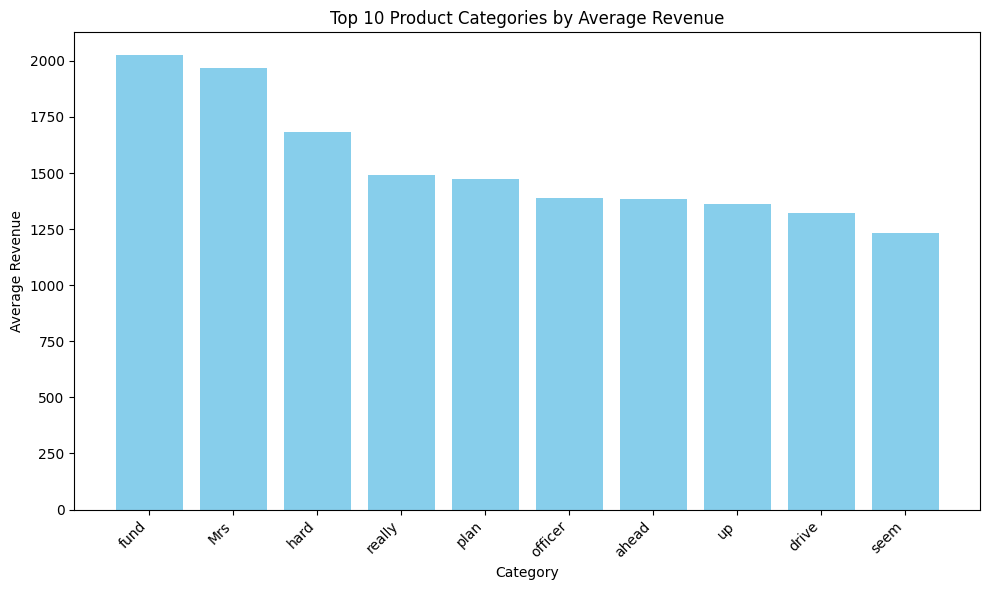

2024-09-19 08:57:12,519 - INFO - Successfully completed plotting.


In [48]:
plot_top_n_average_revenue(df_get_average_revenue_by_category, category_col="category", revenue_col="average_revenue", top_n=10)

### Total Revenue by product

In [49]:
from utils.Data_Visualization.visualization import get_total_revenue_by_product

In [50]:
df_get_total_revenue_by_product = get_total_revenue_by_product(df_order_items=order_item, df_products=product, product_id_col="product_id", quantity_col="quantity", price_col="price", product_name_col="product_name")

2024-09-19 08:57:12,554 - INFO - Starting the process to calculate total revenue by product.
2024-09-19 08:57:12,565 - INFO - Joining order_items with products to get product names.
2024-09-19 08:57:12,574 - INFO - Calculating revenue for each product.
2024-09-19 08:57:12,591 - INFO - Grouping by product_id and product_name to calculate total revenue.
2024-09-19 08:57:12,610 - INFO - Successfully calculated total revenue by product.


In [51]:
df_get_total_revenue_by_product.show()

+----------+------------+-------------+
|product_id|product_name|total_revenue|
+----------+------------+-------------+
|        81|       there|       1802.0|
|       296|    suddenly|       6223.0|
|       386|      budget|        575.0|
|       397|     prevent|      16140.0|
|       102|     feeling|       1772.0|
|       269|         off|       1004.0|
|       299|      appear|       1920.0|
|        21|        rise|      10757.0|
|        33|       glass|      12190.0|
|        61|         try|       3660.0|
|       346|   executive|       1275.0|
|        53|         top|       5104.0|
|       100|    position|        130.0|
|       330|     husband|       5616.0|
|       112|       sense|       1618.0|
|       285|         for|       5850.0|
|        62|     partner|       3660.0|
|        92|         too|       3930.0|
|       314|         not|       3072.0|
|        79|        know|        839.0|
+----------+------------+-------------+
only showing top 20 rows



### Get Inventory Status

In [52]:
from utils.Data_Visualization.visualization import get_inventory_status

In [53]:
df_inventory_status = get_inventory_status(df_order_items=order_item, df_products=product, product_id_col="product_id", product_name_col="product_name", quantity_col="quantity", price_col="price", inventory_col="inventory")


2024-09-19 08:57:14,188 - INFO - Starting the process to determine inventory status by product.
2024-09-19 08:57:14,190 - INFO - Calling get_total_revenue_by_product to get revenue data.
2024-09-19 08:57:14,193 - INFO - Starting the process to calculate total revenue by product.
2024-09-19 08:57:14,206 - INFO - Joining order_items with products to get product names.
2024-09-19 08:57:14,224 - INFO - Calculating revenue for each product.
2024-09-19 08:57:14,251 - INFO - Grouping by product_id and product_name to calculate total revenue.
2024-09-19 08:57:14,283 - INFO - Successfully calculated total revenue by product.
2024-09-19 08:57:14,292 - INFO - Joining total revenue with products to get inventory and determine status.
2024-09-19 08:57:14,324 - INFO - Assigning inventory status based on revenue and inventory conditions.
2024-09-19 08:57:14,363 - INFO - Successfully determined inventory status for each product.


In [54]:
df_inventory_status.show()

+----------+------------+---------+-------------+----------------+
|product_id|product_name|inventory|total_revenue|inventory_status|
+----------+------------+---------+-------------+----------------+
|        81|       there|      440|       1802.0|        In stock|
|       296|    suddenly|      890|       6223.0|        In stock|
|       386|      budget|      128|        575.0|        In stock|
|       397|     prevent|      428|      16140.0|        In stock|
|       102|     feeling|      265|       1772.0|        In stock|
|       269|         off|       84|       1004.0|        In stock|
|       299|      appear|      712|       1920.0|        In stock|
|        21|        rise|      631|      10757.0|        In stock|
|        33|       glass|      541|      12190.0|        In stock|
|        61|         try|      516|       3660.0|        In stock|
|       346|   executive|      639|       1275.0|        In stock|
|        53|         top|      581|       5104.0|        In st

### Inventory Status

In [55]:
from utils.Data_Visualization.visualization import plot_inventory_status_percentage

2024-09-19 08:57:16,824 - INFO - Starting the process to get inventory status and plot it.
2024-09-19 08:57:16,825 - INFO - Calling get_inventory_status to retrieve inventory status for each product.
2024-09-19 08:57:16,828 - INFO - Starting the process to determine inventory status by product.
2024-09-19 08:57:16,829 - INFO - Calling get_total_revenue_by_product to get revenue data.
2024-09-19 08:57:16,831 - INFO - Starting the process to calculate total revenue by product.
2024-09-19 08:57:16,841 - INFO - Joining order_items with products to get product names.
2024-09-19 08:57:16,854 - INFO - Calculating revenue for each product.
2024-09-19 08:57:16,880 - INFO - Grouping by product_id and product_name to calculate total revenue.
2024-09-19 08:57:16,915 - INFO - Successfully calculated total revenue by product.
2024-09-19 08:57:16,924 - INFO - Joining total revenue with products to get inventory and determine status.
2024-09-19 08:57:16,961 - INFO - Assigning inventory status based on

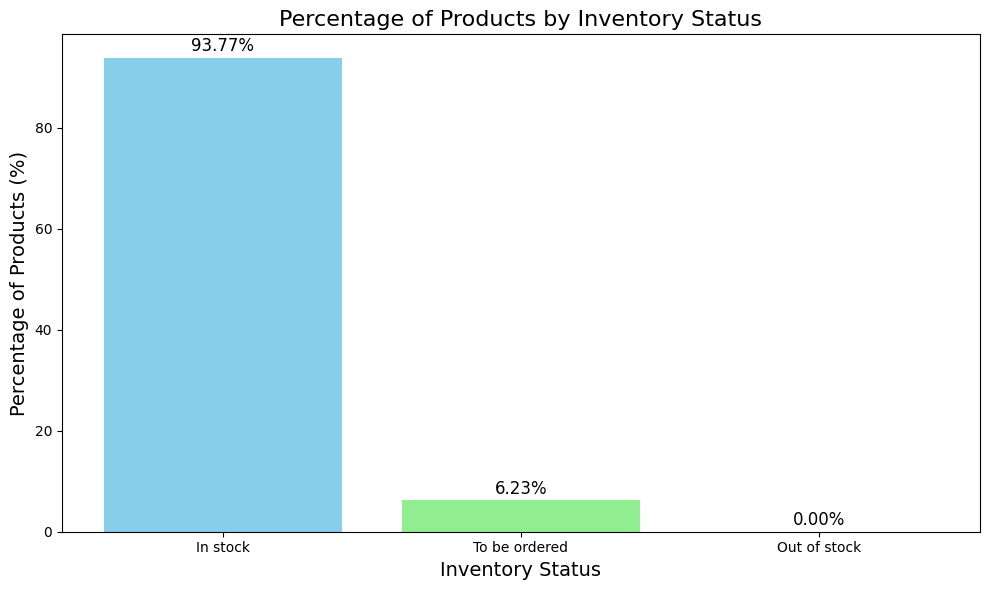

2024-09-19 08:57:19,936 - INFO - Successfully completed plotting.


In [56]:
plot_inventory_status_percentage(df_order_items=order_item, df_products=product, product_id_col="product_id", product_name_col="product_name", quantity_col="quantity", price_col="price", inventory_col="inventory")

### CLV

In [57]:
from utils.Data_Visualization.visualization import calculate_customer_lifetime_value

In [58]:
df_calculate_customer_lifetime_value = calculate_customer_lifetime_value(df_order_items=order_item, df_orders=order, df_customers=customer, order_id_col="order_id", customer_id_col="customer_id", price_col="price", quantity_col="quantity", first_name_col="first_name", last_name_col="last_name")

2024-09-19 08:57:19,960 - INFO - Starting the process to calculate CLV for each customer.
2024-09-19 08:57:19,971 - INFO - Joining order_items with orders to get customer_id.
2024-09-19 08:57:19,986 - INFO - Calculating revenue for each order item.
2024-09-19 08:57:19,998 - INFO - Grouping by customer_id and calculating total revenue (CLV).
2024-09-19 08:57:20,027 - INFO - Joining CLV DataFrame with customers to get customer names.
2024-09-19 08:57:20,044 - INFO - Successfully calculated CLV and joined with customer names.


In [59]:
df_calculate_customer_lifetime_value.show()

+-----------+-------------------+----+
|customer_id|      customer_name| CLV|
+-----------+-------------------+----+
|       4894|      Penny Fleming| 243|
|       3800|          Leslie Yu| 767|
|       4126|       Matthew Huff| 957|
|       1258|      Madison Weiss| 475|
|       3199|   Douglas Gonzalez| 282|
|       3704|    Samantha Dillon|1925|
|        720|       Heidi Miller|1548|
|        847|     Jennifer Hines| 798|
|       1958|     Jonathan Garza|1690|
|       1921|      Emily Johnson|1176|
|       4113|Christopher Ramirez| 205|
|        656|    Sharon Campbell|1253|
|       2244|        John Martin| 371|
|       1042| Timothy Villarreal| 254|
|        385|     Kayla Davidson|1392|
|       3491|      Andrew Parker| 623|
|       4478|     Melissa Morgan|2335|
|       2439|  Timothy Hernandez|3063|
|       2473|      Thomas Bailey| 921|
|       4413|       Bruce Miller|1441|
+-----------+-------------------+----+
only showing top 20 rows



In [60]:
from utils.Data_Visualization.visualization import plot_top_n_premium_customers

2024-09-19 08:57:22,338 - INFO - Starting the plotting process for top 10 premium customers based on CLV.
2024-09-19 08:57:22,344 - INFO - Sorting the DataFrame by CLV and selecting the top 10 customers.
2024-09-19 08:57:22,382 - INFO - Collecting the data for plotting.
2024-09-19 08:57:24,535 - INFO - Plotting the top premium customers by CLV.


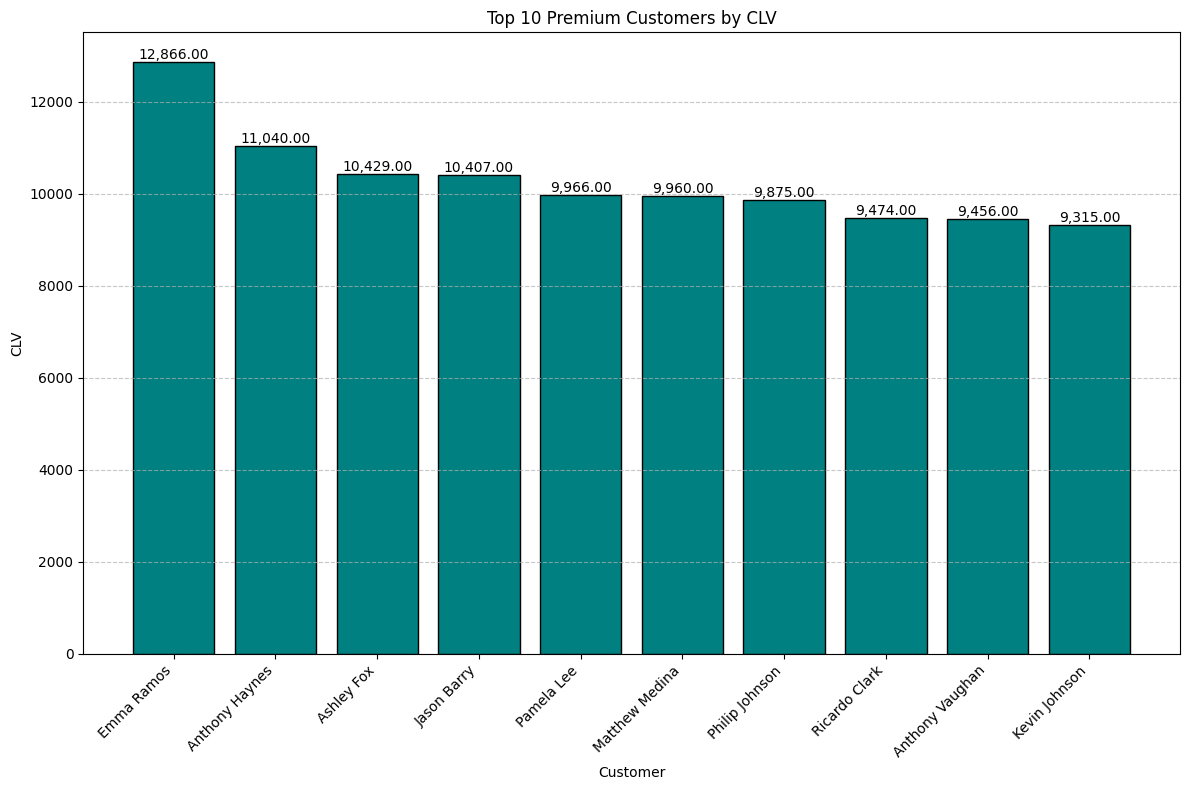

2024-09-19 08:57:24,783 - INFO - Successfully completed plotting.


In [61]:
plot_top_n_premium_customers(df_customer_clv=df_calculate_customer_lifetime_value, customer_name_col="customer_name", clv_col="CLV", top_n=10)

In [62]:
from utils.Data_Visualization.visualization import calculate_yearly_revenue

In [63]:
df_calculate_yearly_revenue = calculate_yearly_revenue(df_orders=order, df_order_items=order_item, order_id_col="order_id", order_date_col="order_date", price_col="price", quantity_col="quantity")

2024-09-19 08:57:24,825 - INFO - Starting the calculation of yearly revenue.
2024-09-19 08:57:24,828 - INFO - Calculating revenue for each order item.
2024-09-19 08:57:24,848 - INFO - Joining order items with orders to get the order_date.
2024-09-19 08:57:24,877 - INFO - Extracting the year from the order_date.
2024-09-19 08:57:24,920 - INFO - Aggregating total revenue by year.
2024-09-19 08:57:24,961 - INFO - Successfully calculated yearly revenue.


In [64]:
df_calculate_yearly_revenue.show()

+----+-------------+
|year|total_revenue|
+----+-------------+
|2025|        84088|
|2023|       621244|
|2022|       686147|
|2019|       229329|
|2020|       601361|
|2024|       435985|
|2021|       631219|
+----+-------------+



In [65]:
from utils.Data_Visualization.visualization import plot_yearly_revenue

2024-09-19 08:57:26,226 - INFO - Starting the plotting process for yearly revenue.


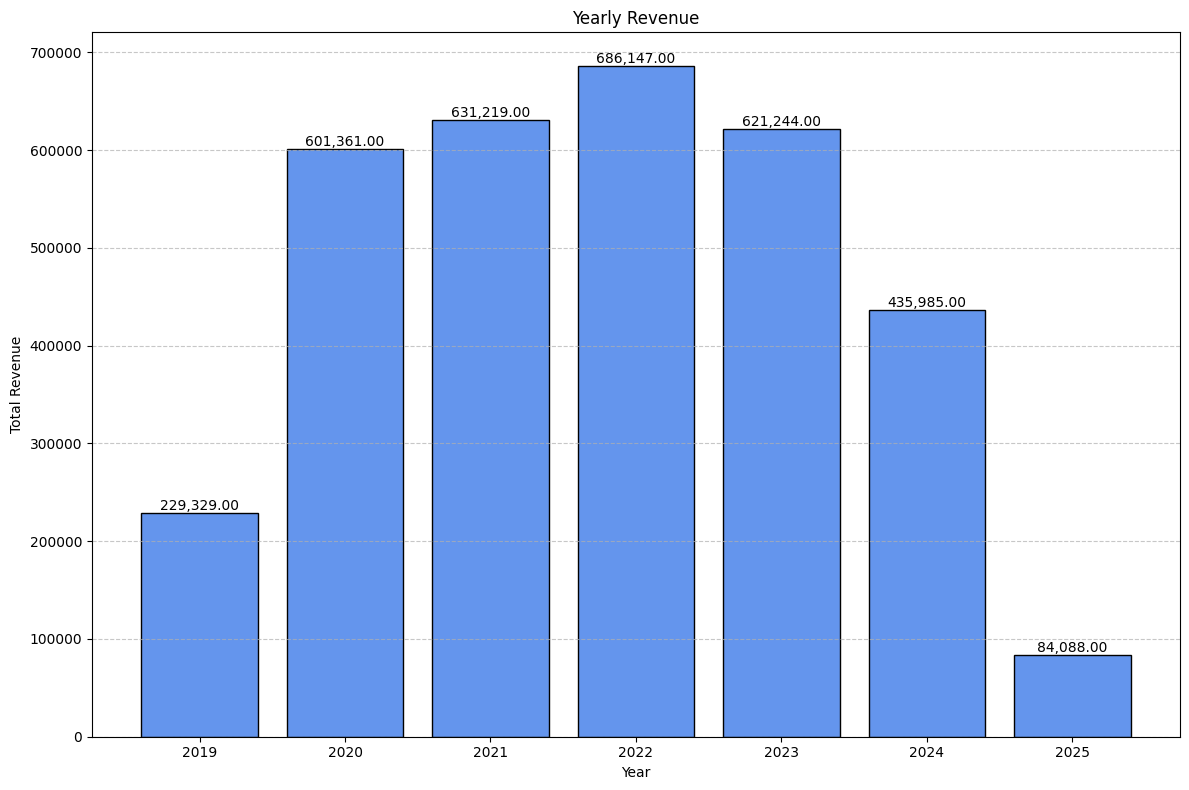

2024-09-19 08:57:27,733 - INFO - Successfully completed plotting yearly revenue.


In [66]:
plot_yearly_revenue(df_yearly_revenue=df_calculate_yearly_revenue, year_col="year", total_revenue_col="total_revenue")

In [67]:
from utils.Data_Visualization.visualization import get_max_orders_per_year


In [68]:
df_get_max_orders_per_year = get_max_orders_per_year(df_orders=order, order_date_col="order_date", order_id_col="order_id")

2024-09-19 08:57:27,758 - INFO - Starting the process to calculate maximum orders per year.
2024-09-19 08:57:27,759 - INFO - Extracting year from the order_date column.
2024-09-19 08:57:27,773 - INFO - Counting the number of orders per year.
2024-09-19 08:57:27,794 - INFO - Finding the maximum number of orders per year.
2024-09-19 08:57:27,816 - INFO - Successfully calculated maximum orders per year.


In [69]:
df_get_max_orders_per_year.show()

+----+----------+
|year|max_orders|
+----+----------+
|2025|       121|
|2023|       943|
|2022|       970|
|2019|       329|
|2020|       978|
|2024|       701|
|2021|       958|
+----+----------+



In [70]:
from utils.Data_Visualization.visualization import plot_max_orders_per_year

2024-09-19 08:57:28,478 - INFO - Starting the plotting process for maximum orders per year.
2024-09-19 08:57:28,481 - INFO - Collecting the data for plotting.
2024-09-19 08:57:29,163 - INFO - Plotting the maximum orders per year.


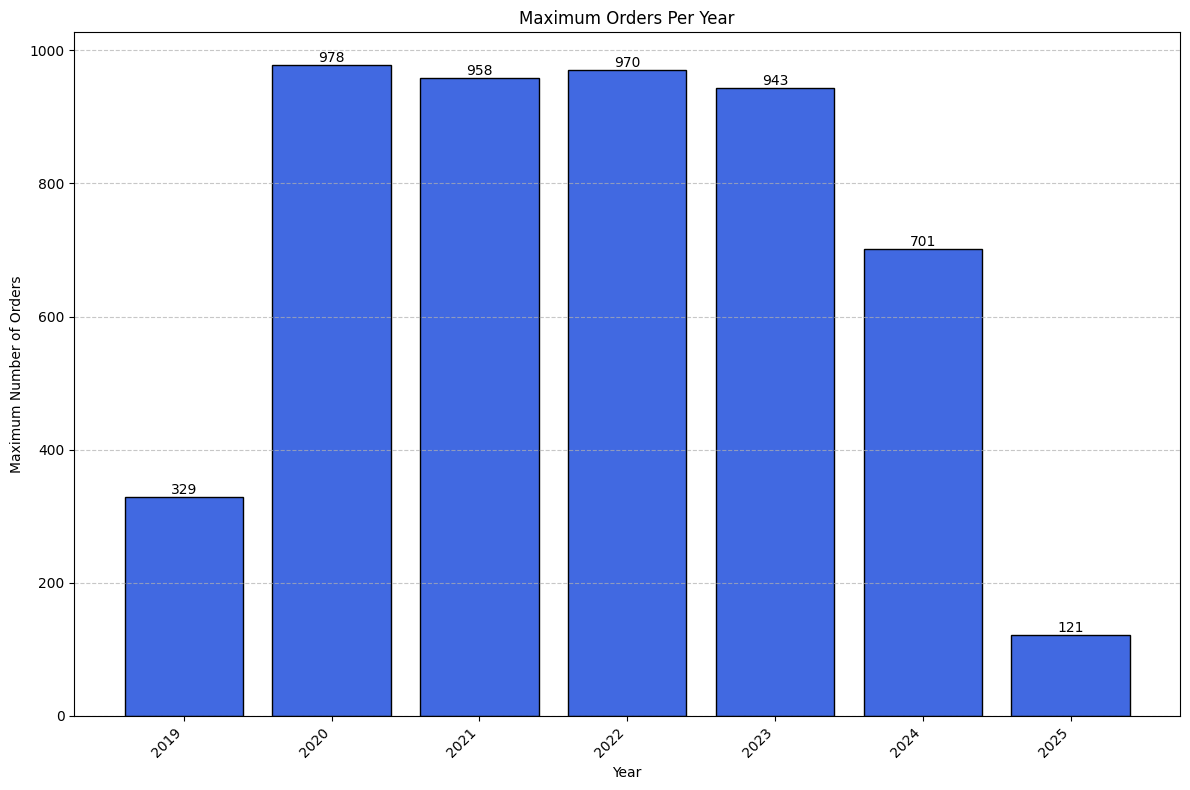

2024-09-19 08:57:29,341 - INFO - Successfully completed plotting.


In [71]:
plot_max_orders_per_year(df_max_orders=df_get_max_orders_per_year, year_col="year", max_orders_col="max_orders")

In [72]:
from utils.Data_Visualization.visualization import categorize_reviews

In [73]:
df_categorize_review = categorize_reviews(df_reviews=review, df_products=product, review_id_col="review_id", rating_col="rating", product_id_col="product_id", product_name_col="product_name")

In [74]:
df_categorize_review.show()

+----------+-------------+--------------+----------------+
|product_id| product_name|average_rating| rating_category|
+----------+-------------+--------------+----------------+
|         2|        happy|             4|highly-satisfied|
|         3|         same|             3|    satisfactory|
|         4|      prevent|             4|highly-satisfied|
|         5|        quite|             0|         unknown|
|         7|       beyond|             4|highly-satisfied|
|         8|     although|             1|            poor|
|         9|environmental|             2|         average|
|        12|        their|             4|highly-satisfied|
|        13|         fine|             5|       excellent|
|        15|     approach|             1|            poor|
|        16|         mind|             2|         average|
|        17|  opportunity|             4|highly-satisfied|
|        18|         pull|             3|    satisfactory|
|        19|         step|             5|       excellen

In [75]:
from utils.Data_Visualization.visualization import plot_top_n_product_ratings

2024-09-19 08:57:31,226 - INFO - Starting the plotting process for top 10 products with highest average ratings.
2024-09-19 08:57:31,230 - INFO - Sorting the DataFrame by average_rating and selecting the top 10.
2024-09-19 08:57:31,255 - INFO - Collecting data from DataFrame.
2024-09-19 08:57:32,890 - INFO - Extracted product names, ratings, and categories.
2024-09-19 08:57:32,947 - INFO - Plotting top 10 products with highest average ratings.


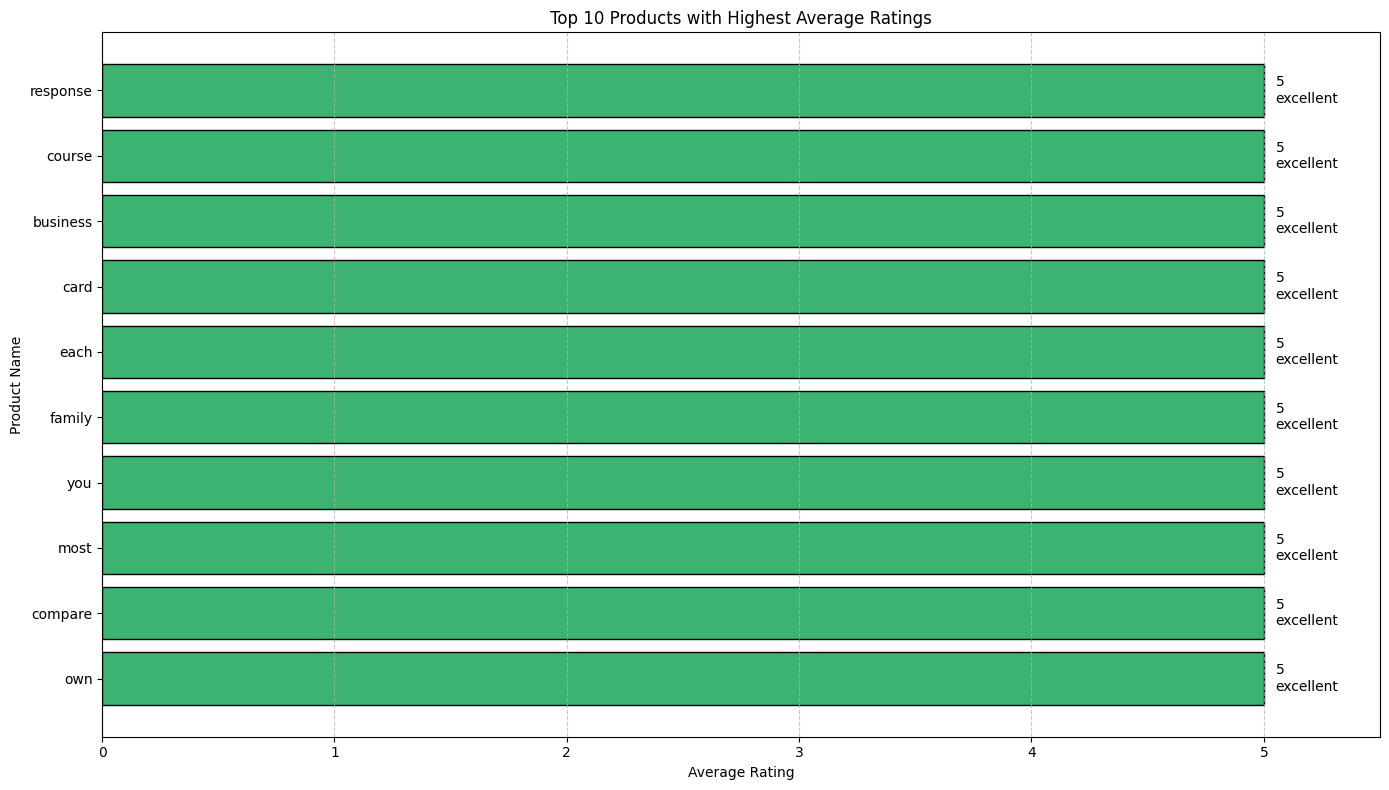

2024-09-19 08:57:33,111 - INFO - Plot displayed successfully.


In [76]:
plot_top_n_product_ratings(df_categorize_reviews = df_categorize_review, product_id_col="product_id", product_name_col="product_name", average_rating_col="average_rating", rating_category_col="rating_category", top_n=10)